In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import datetime
import math

In [2]:
# Import the observations data.
# Column names for observed mongoose counts follow this scheme:
#   S = susceptible
#   I = infected
#   T = total
#   M = male
#   F = female
#   U = unknown sex
#   A = adult
#   S = sub-adult
#   J = juvenile
#   P = pregnant,
#   L = lactating
#   EN = enlarged nipples
# For example, susceptible juvenile males would be in column 'SJM'.

obs_data = pd.read_csv('../Mongoose Modeling/Observations.csv', parse_dates=['ObservationTime'])
#obs_data = obs_data[obs_data.columns.drop(list(obs_data.filter(regex='Uncertain')))]

In [3]:
obs_data.head()

,ObservationID,ObservationTime,ObservationTimeApproximate,Troop,Observer,ObservationType,UTMNorthing,UTMEasting,LocationApproximate,LocationDescription,...,ISU,ISUUncertain,IJ,IJUncertain,IJM,IJMUncertain,IJF,IJFUncertain,IJU,IJUUncertain
0,kub0805021700,2008-05-02 17:00:00,0,KUB,NaN,Fatality,8031619,312657,0,Butch & Ebbie's house,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,cgl0805061010,2008-05-06 10:10:00,0,CGL,Mpho Ramotadima,Foraging,8026213,296182,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,cch0805061312,2008-05-06 13:12:00,0,CCH,Mpho Ramotadima,Resting,8027955,302179,0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,mow0805131441,2008-05-13 14:41:00,0,MOW,NaN,Capture,8032937,304888,1,Mowana,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,mow0805140828,2008-05-14 08:28:00,0,MOW,NaN,Capture,8032937,304888,0,mowana trash site,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Infer missing values where component values roll up to a sum.
# (e.g. total susceptible = susceptible adults + susceptible sub-adults + susceptible juveniles)

def infer_observations(df, total_column, component_columns):
    df[total_column] = df.apply(
        # total should be the sum of the components (ignoring NaN), but we ignore when the total is zero
        lambda row: (row[component_columns].sum() if row[component_columns].sum() > 0 else np.nan) if np.isnan(row[total_column]) else row[total_column],
        axis = 1
    )
    for col in component_columns:
        df[col] = df.apply(
            # components should be the tota minus the other components (if all other components are present)
            lambda row: row[total_column]-(row[[x for x in component_columns if x != col]].sum(skipna=False)) if np.isnan(row[col]) else row[col],
            axis = 1
        )

initial_counts = obs_data.count()

# susceptible/infected counts by sex should be the sum of susceptible/infected 
# counts by sex broken down by age group
infer_observations(obs_data, 'SM', ['SAM','SSM','SJM'])
infer_observations(obs_data, 'IM', ['IAM','ISM','IJM'])
infer_observations(obs_data, 'SF', ['SAF','SSF','SJF'])
infer_observations(obs_data, 'IF', ['IAF','ISF','IJF'])
infer_observations(obs_data, 'SU', ['SAU','SSU','SJU'])
infer_observations(obs_data, 'IU', ['IAU','ISU','IJU'])
# susceptible/infected totals should be the sum of susceptible/infected
# counts broken down by age group and broken down by sex
infer_observations(obs_data, 'ST', ['SA','SS','SJ'])
infer_observations(obs_data, 'IT', ['IA','IS','IJ'])
infer_observations(obs_data, 'ST', ['SM','SF','SU'])
infer_observations(obs_data, 'IT', ['IM','IF','IU'])

print('{} observation counts inferred.'.format((obs_data.count()-initial_counts).sum()))

1217 observation counts inferred.


In [5]:
# Add a column for total count
obs_data['T'] = (obs_data['ST'].fillna(0) + obs_data['IT'].fillna(0)).replace(0, np.nan)

# Add columns for total count by age group.
obs_data['A'] = (obs_data['SA'].fillna(0) + obs_data['IA'].fillna(0)).replace(0, np.nan)
obs_data['S'] = (obs_data['SS'].fillna(0) + obs_data['IS'].fillna(0)).replace(0, np.nan)
obs_data['J'] = (obs_data['SJ'].fillna(0) + obs_data['IJ'].fillna(0)).replace(0, np.nan)

##Dataframe shape before removing NaNs
obs_data.shape

(20851, 91)

In [6]:
##Remove NaNs in T column (no troop number observations)
obs_data = obs_data.dropna(subset=['T'])
obs_data.shape

(1944, 91)

In [7]:
# Compute basic statistics about the observed total counts per troop.
obs_data.groupby(obs_data['Troop']).agg({'T':{'count','mean','min','max'},
                                         'A':{'count','mean','min','max'},
                                         'S':{'count','mean','min','max'},
                                         'J':{'count','mean','min','max'}})

A                           J                            T        \
        min count   max       mean  min count   max       mean   min count   
Troop                                                                        
AIR     5.0     3   7.0   6.333333  4.0     1   4.0   4.000000   4.0     4   
BDF     NaN     0   NaN        NaN  NaN     0   NaN        NaN  15.0     7   
BOR     NaN     0   NaN        NaN  NaN     0   NaN        NaN  21.0     1   
CCH     1.0    67  45.0  12.731343 -2.0    35  23.0   8.228571   2.0   104   
CGL     2.0    82  49.0  20.731707 -1.0    39  24.0   8.923077   1.0   173   
COR     NaN     0   NaN        NaN  NaN     0   NaN        NaN   7.0     1   
CSL     1.0   149  31.0  12.657718  1.0   126  17.0   5.452381   1.0   893   
DUM     NaN     0   NaN        NaN  NaN     0   NaN        NaN  10.0     4   
DWN     NaN     0   NaN        NaN  NaN     0   NaN        NaN   2.0     2   
EVL     2.0    15  21.0   8.866667  3.0     5  13.0   7.400000   2.0    27   
HIP     1.0    42  28.0  13.333333  1.0    12  21.0   5.916667   1.0    67   
IHA     NaN     0   NaN        NaN  NaN     0   NaN        NaN   9.0     1   
IHE     NaN     0   NaN        NaN  NaN     0   NaN        NaN  16.0     1   
IHW     NaN     0   NaN        NaN  NaN     0   NaN        NaN  13.0     2   
KAB     6.0     2   8.0   7.000000  4.0     2   5.0   4.500000  13.0     2   
KAL    10.0     1  10.0  10.000000  NaN     0   NaN        NaN  10.0     1   
KAZ     1.0     4  19.0  11.250000  6.0     2  26.0  16.000000   1.0    18   
KBV     NaN     0   NaN        NaN  NaN     0   NaN        NaN   8.0     2   
KIN    41.0     1  41.0  41.000000  NaN     0   NaN        NaN  41.0     1   
KUB     1.0   110  30.0   9.627273  1.0    37  15.0   6.918919   1.0   176   
KYM     NaN     0   NaN        NaN  NaN     0   NaN        NaN  18.0     2   
LES    14.0     1  14.0  14.000000  NaN     0   NaN        NaN   7.0     3   
MAR     NaN     0   NaN        NaN  5.0     1   5.0   5.000000  20.0     1   
MOW     1.0    94   8.0   3.308511  1.0    57   6.0   2.684211   1.0   138   
NAE     NaN     0   NaN        NaN  NaN     0   NaN        NaN  20.0     1   
NAW     NaN     0   NaN        NaN  NaN     0   NaN        NaN   9.0     2   
NMW     5.0     3   7.0   5.666667  NaN     0   NaN        NaN   5.0     5   
OPG    11.0     2  14.0  12.500000  4.0     1   4.0   4.000000   6.0     7   
SEF     1.0   108   8.0   4.203704  1.0    57  15.0   3.210526   1.0   128   
SEJ     3.0    18  16.0   8.611111  1.0     4   4.0   2.500000   7.0    26   
SER     5.0     1   5.0   5.000000  1.0     1   1.0   1.000000   6.0     3   
SEV     NaN     0   NaN        NaN  NaN     0   NaN        NaN  25.0     2   
SIJ     NaN     0   NaN        NaN  5.0     1   5.0   5.000000   6.0     8   
TRS     1.0    69  14.0   4.869565  1.0    15   8.0   2.933333   1.0   113   
VSL     NaN     0   NaN        NaN  NaN     0   NaN        NaN   4.0     1   
WCJ    11.0     9  18.0  13.444444  1.0     4  10.0   4.500000   4.0    15   
WHS     NaN     0   NaN        NaN  NaN     0   NaN        NaN  11.0     1   
ZEB    11.0     1  11.0  11.000000  NaN     0   NaN        NaN  17.0     1   

                           S                        
        max       mean   min count   max      mean  
Troop                                               
AIR    12.0   8.250000   1.0     2   5.0  3.000000  
BDF    30.0  21.142857   NaN     0   NaN       NaN  
BOR    21.0  21.000000   NaN     0   NaN       NaN  
CCH    51.0  23.951923   1.0    36  34.0  8.194444  
CGL    69.0  28.485549 -13.0    63  25.0  7.142857  
COR     7.0   7.000000   NaN     0   NaN       NaN  
CSL    68.0  14.226204  -5.0   108  27.0  9.750000  
DUM    30.0  20.000000   NaN     0   NaN       NaN  
DWN     4.0   3.000000   NaN     0   NaN       NaN  
EVL    31.0  14.555556   1.0     4   7.0  3.000000  
HIP    53.0  18.044776   1.0    23  10.0  5.565217  
IHA     9.0   9.000000   NaN     0   NaN       NaN  
IHE    16.0  16.

In [8]:
obs_data['TimeSinceLast'] = obs_data.groupby('Troop')['ObservationTime'].transform(lambda x: x.dt.date.diff())
obs_data['TDiff'] = obs_data.groupby('Troop')['T'].transform(lambda x: x.where(x.isnull(), x.fillna(method='ffill').diff()))
obs_data[['TimeSinceLast','TDiff']].describe()

,TimeSinceLast,TDiff
count,1906,1906.000000
mean,8 days 00:37:46.526757,-0.030955
std,39 days 20:36:09.362566,11.316751
min,0 days 00:00:00,-59.000000
25%,0 days 00:00:00,-5.000000
50%,1 days 00:00:00,0.000000
75%,4 days 00:00:00,4.000000
max,971 days 00:00:00,56.000000


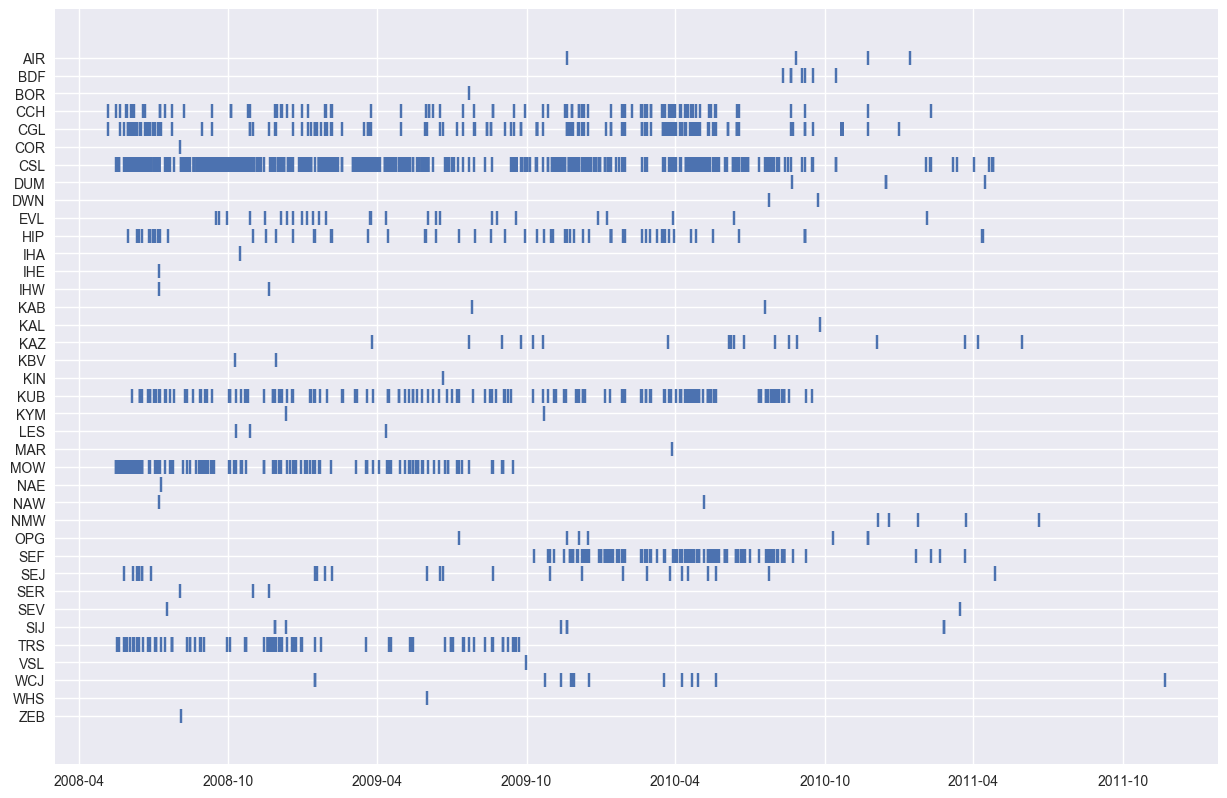

In [9]:
obs_dates = obs_data.groupby('Troop')['ObservationTime'].apply(list).sort_index(ascending=False)
fig, ax = plt.subplots(figsize=(15, 10), dpi=100)
plt.eventplot(obs_dates, linelengths=0.8)
plt.yticks(np.arange(len(obs_dates)), list(obs_dates.index))
plt.show()

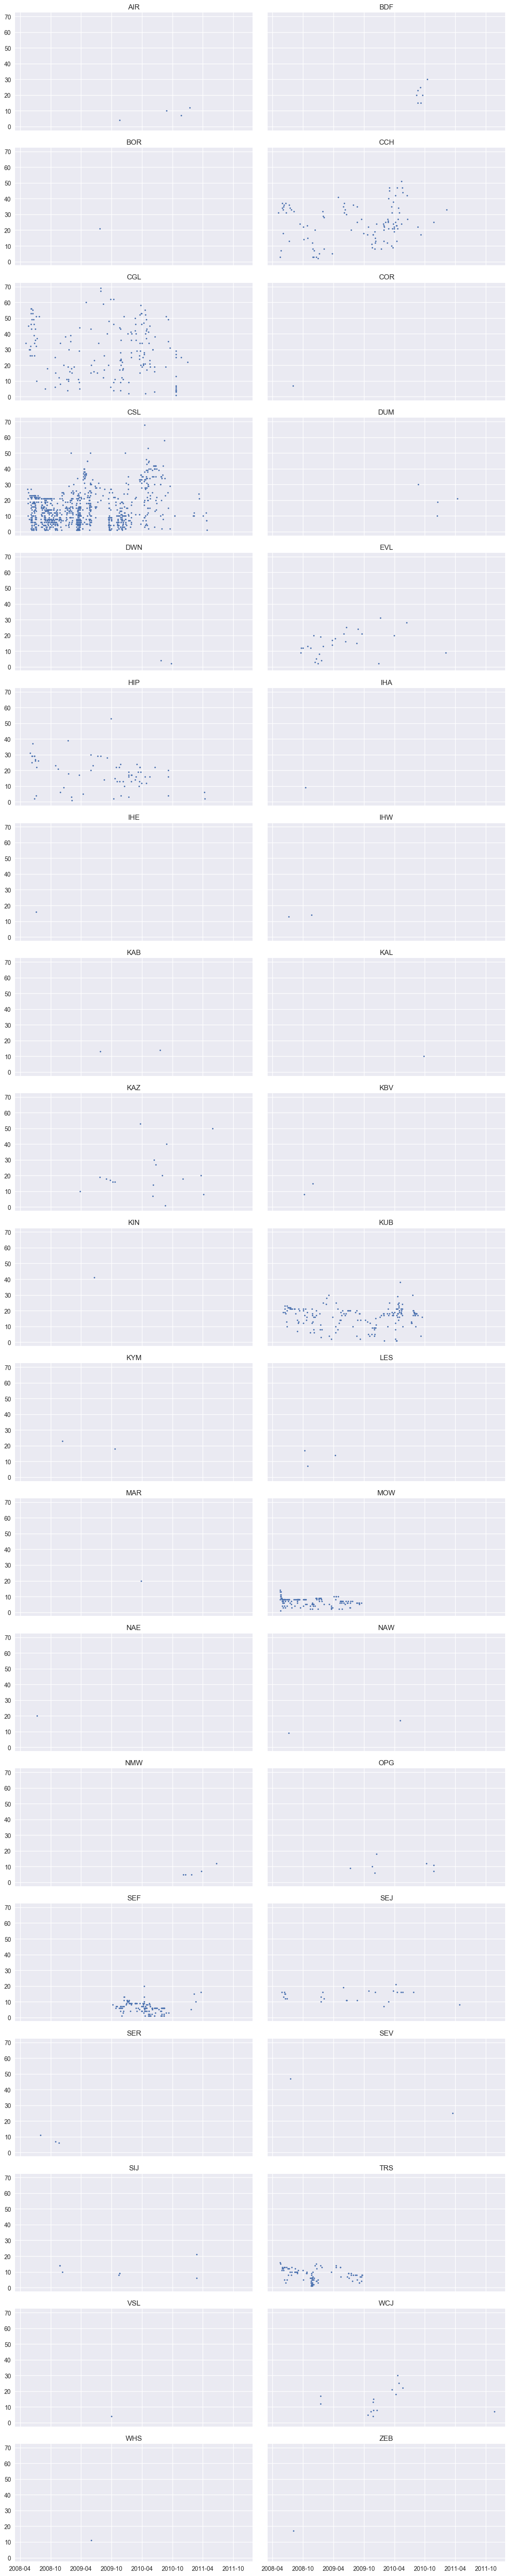

In [10]:
troops = sorted(obs_data['Troop'].unique())
fig,ax = plt.subplots(nrows=math.ceil(len(troops)/2), ncols=2, figsize=(12, 60), dpi=100, sharex='all', sharey='all', )
for idx, troop in enumerate(troops):
    troop_data = obs_data[obs_data['Troop']==troop]
    axes = ax[math.floor(idx/2), idx%2]
    axes.plot_date(x=troop_data['ObservationTime'], y=troop_data['T'], markersize=2.5)
    axes.set_title(troop)
plt.tight_layout()

In [11]:
##Determine number of observations for each troop
##NEED TO COME BACK HERE AND REMOVE NANS
dates = pd.DataFrame(data = obs_dates).reset_index().sort_values(by=['Troop']).reset_index(drop=True)
dates['ObsLen'] = dates.ObservationTime.apply(lambda x: len(x))
dates = dates.sort_values(by=['ObsLen'],ascending=False).reset_index(drop=True)
dates.head()


,Troop,ObservationTime,ObsLen
0,CSL,"[2008-05-16 16:05:00, 2008-05-17 08:55:00, 200...",893
1,KUB,"[2008-06-04 14:20:00, 2008-06-14 09:35:00, 200...",176
2,CGL,"[2008-05-06 10:10:00, 2008-05-21 13:45:00, 200...",173
3,MOW,"[2008-05-16 11:25:00, 2008-05-16 17:00:00, 200...",138
4,SEF,"[2009-10-09 16:00:00, 2009-10-27 08:15:00, 200...",128


In [12]:
##List of groups that have more than 6 observations
##Need at least one observation a month for 6 months
dates = dates.loc[dates.ObsLen > 6]
good_troops = list(dates.Troop)
good_troops

['CSL',
 'KUB',
 'CGL',
 'MOW',
 'SEF',
 'TRS',
 'CCH',
 'HIP',
 'EVL',
 'SEJ',
 'KAZ',
 'WCJ',
 'SIJ',
 'OPG',
 'BDF']

In [13]:
##Grabbing the data from full obs_data set that meets at least 6 observations
good_data = obs_data.loc[obs_data['Troop'].isin(good_troops)]
good_data.Troop.unique()


array(['CGL', 'CCH', 'MOW', 'CSL', 'TRS', 'SEJ', 'HIP', 'KUB', 'EVL',
       'SIJ', 'WCJ', 'KAZ', 'OPG', 'SEF', 'BDF'], dtype=object)

In [14]:
##Identifying and creating month and year column for all observations in good_data
good_data['ObsYear'] = good_data.ObservationTime.apply(lambda x: x.year)
good_data['ObsMonth'] = good_data.ObservationTime.apply(lambda x: x.month)


c:\users\gabss\appdata\local\enthought\canopy\edm\envs\user\lib\site-packages\ipykernel\__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
c:\users\gabss\appdata\local\enthought\canopy\edm\envs\user\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [15]:
##Grouping good_data by troop and year
##May not be used in future code, but exists just in case

sig_data = good_data.groupby(['Troop','ObsYear'])
sig_data.get_group(('CCH',2008))

,ObservationID,ObservationTime,ObservationTimeApproximate,Troop,Observer,ObservationType,UTMNorthing,UTMEasting,LocationApproximate,LocationDescription,...,IJU,IJUUncertain,T,A,S,J,TimeSinceLast,TDiff,ObsYear,ObsMonth
2,cch0805061312,2008-05-06 13:12:00,0,CCH,Mpho Ramotadima,Resting,8027955,302179,0,NaN,...,NaN,NaN,31.0,NaN,NaN,NaN,NaT,NaN,2008,5
8,cch0805161505,2008-05-16 15:05:00,0,CCH,Pete Laver,Foraging,8027703,302507,0,NaN,...,NaN,NaN,3.0,3.0,NaN,NaN,10 days,-28.0,2008,5
54,cch0805201610,2008-05-20 16:10:00,0,CCH,Mpho Ramotadima,Moving,8027896,302774,0,NaN,...,NaN,NaN,7.0,7.0,NaN,NaN,4 days,4.0,2008,5
96,cch0805280802,2008-05-28 08:02:00,0,CCH,Mpho Ramotadima,Foraging,8027835,302520,0,NaN,...,NaN,NaN,37.0,NaN,NaN,NaN,8 days,30.0,2008,5
117,cch0805300730,2008-05-30 07:30:00,0,CCH,Pete Laver,Denning,8027951,302571,0,1st cottage to west of lodge,...,NaN,NaN,34.0,NaN,NaN,NaN,2 days,-3.0,2008,5
154,cch0806031456,2008-06-03 14:56:00,0,CCH,Pete Laver,Foraging,8027763,302568,0,NaN,...,NaN,NaN,33.0,NaN,NaN,NaN,4 days,-1.0,2008,6
165,cch0806041115,2008-06-04 11:15:00,0,CCH,Pete Laver,Resting,8028016,302209,0,NaN,...,NaN,NaN,18.0,NaN,NaN,NaN,1 days,-15.0,2008,6
181,cch0806051630,2008-06-05 16:30:00,0,CCH,Pete Laver,Foraging,8027936,302592,0,NaN,...,NaN,NaN,35.0,NaN,NaN,2.0,1 days,17.0,2008,6
200,cch0806071120,2008-06-07 11:20:00,0,CCH,Pete Laver,Foraging,8027892,302767,0,NaN,...,NaN,NaN,36.0,12.0,15.0,1.0,2 days,1.0,2008,6
318,cch0806181540,2008-06-18 15:40:00,0,CCH,Pete Laver,Foraging,8027811,302503,0,NaN,...,NaN,NaN,37.0,NaN,NaN,NaN,11 days,1.0,2008,6


In [16]:
##Quick look of the months and years present for observations for each troop
for i in good_data.Troop.unique():
    for j in good_data.loc[good_data.Troop == i].ObsYear.unique():
        print('Troop: '+str(i))
        print('Year: '+str(j))
        print(list(sig_data.get_group((str(i),j)).ObsMonth.unique()))

Troop: CGL
Year: 2008
[5, 6, 7, 8, 9, 10, 11, 12]
Troop: CGL
Year: 2009
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Troop: CGL
Year: 2010
[1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12]
Troop: CCH
Year: 2008
[5, 6, 7, 8, 9, 10, 11, 12]
Troop: CCH
Year: 2009
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Troop: CCH
Year: 2010
[1, 2, 3, 4, 5, 6, 8, 9, 11]
Troop: CCH
Year: 2011
[2]
Troop: MOW
Year: 2008
[5, 6, 7, 8, 9, 10, 11, 12]
Troop: MOW
Year: 2009
[1, 2, 3, 4, 5, 6, 7, 8, 9]
Troop: CSL
Year: 2008
[5, 6, 7, 8, 9, 10, 11, 12]
Troop: CSL
Year: 2009
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Troop: CSL
Year: 2010
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
Troop: CSL
Year: 2011
[2, 3, 4]
Troop: TRS
Year: 2008
[5, 6, 7, 8, 9, 10, 11, 12]
Troop: TRS
Year: 2009
[1, 3, 4, 5, 6, 7, 8, 9]
Troop: SEJ
Year: 2008
[5, 6]
Troop: SEJ
Year: 2009
[1, 2, 5, 6, 8, 10, 12]
Troop: SEJ
Year: 2010
[1, 2, 3, 4, 5, 7]
Troop: SEJ
Year: 2011
[4]
Troop: HIP
Year: 2008
[5, 6, 7, 10, 11, 12]
Troop: HIP
Year: 2009
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 1

# Cleaning Pete's Data by Function

In [17]:
##Input a troop name to find consecutive (at least 6 months) data
##Will return a dataframe with months to keep (Keep = 1) and months to discard (Keep == 0)
##Simply need df.loc[df.Keep != 0]

def consec6(troop):
    months = []
    years = []
    count = 0
    tag = 0 ##keeps track if count hit 5 or greater
    
    for i in good_data.loc[good_data.Troop == troop].ObsYear.unique():
        years.extend([i]*len(sig_data.get_group((troop,i)).ObsMonth.unique()))
        months.extend(sig_data.get_group((troop,i)).ObsMonth.unique())
        
    df = pd.DataFrame({'Year':years,'Month':months,'Keep':[0]*len(months)})
    
    df['mon_elap'] = df.Month + 12*(df.Year-list(df.Year)[0])

    for x in range(len(months)-1):
        ##Next unique month consecutive number?
        if df.loc[x+1,'mon_elap'] == df.loc[x,'mon_elap']+1:
            count += 1
            ##End of df and count >= 5? Mark as keep
            if (x == len(months)-2) & (count >= 5):
                df.loc[x-count:x+1,'Keep'] = 3
                #print('loc 5')
            #print('loc 1')
    
        ##No longer consecutive and under 6 months? Start over.
        elif (df.loc[x+1,'mon_elap'] != df.loc[x,'mon_elap']+1) & (count < 5):
            count = 0 
            #print('loc 2')

        ##6 months or over and no longer consecutive? Mark as keep
        elif (df.loc[x+1,'mon_elap'] != df.loc[x,'mon_elap']+1) & (count >= 5):
            df.loc[x-count:x,'Keep'] = 1
            count = 0
            #print('loc 3')
            
        ##All Keep entries are 0 at very end?    
        if (np.sum(df.Keep) == 0) & (count >= 5) & (x == len(months)-2):
            df.loc[x-count:x+1,'Keep'] = 2
            #print('loc 4')
            

            
    #print('count is {}'.format(count))

    return df



In [18]:
consec6('KAZ')

,Keep,Month,Year,mon_elap
0,0,3,2009,3
1,0,7,2009,7
2,0,8,2009,8
3,0,9,2009,9
4,0,10,2009,10
5,0,3,2010,15
6,0,6,2010,18
7,0,8,2010,20
8,0,12,2010,24
9,0,3,2011,27


# Cleaning Pete's Data By Hand

In [19]:
wd = good_data
wd.loc[:,'Keep'] = 1

##Remove CCH 11-2010
temp = wd.loc[(wd.Troop == 'CCH')&(wd.ObsMonth == 11)&(wd.ObsYear == 2010)]
temp.loc[:,'Keep'] = 0
wd.update(temp)

##Remove CCH 2-2011
temp = wd.loc[(wd.Troop == 'CCH')&(wd.ObsMonth == 2)&(wd.ObsYear == 2011)]
temp.loc[:,'Keep'] = 0
wd.update(temp)

##Remove CSL [2-4]-2011
temp = wd.loc[(wd.Troop == 'CSL')&(wd.ObsMonth <= 4)&(wd.ObsMonth >= 2)&(wd.ObsYear == 2011)]
temp.loc[:,'Keep'] = 0
wd.update(temp)

##Remove SEJ 2008, [1-11]-2009, 7-2010, 2011
temp = wd.loc[(wd.Troop == 'SEJ')&(wd.ObsYear == 2008)]
temp.loc[:,'Keep'] = 0
wd.update(temp)

temp = wd.loc[(wd.Troop == 'SEJ')&(wd.ObsMonth >= 1)&(wd.ObsMonth <= 11)&(wd.ObsYear == 2009)]
temp.loc[:,'Keep'] = 0
wd.update(temp)

temp = wd.loc[(wd.Troop == 'SEJ')&(wd.ObsMonth == 7)&(wd.ObsYear == 2010)]
temp.loc[:,'Keep'] = 0 
wd.update(temp)

temp = wd.loc[(wd.Troop == 'SEJ')&(wd.ObsYear == 2011)]
temp.loc[:,'Keep'] = 0
wd.update(temp)

##Remove HIP [5-7]-2008, 9-2010, 2011
temp = wd.loc[(wd.Troop == 'HIP')&(wd.ObsMonth >= 5)&(wd.ObsMonth <= 7)&(wd.ObsYear == 2008)]
temp.loc[:,'Keep'] = 0
wd.update(temp)

temp = wd.loc[(wd.Troop == 'HIP')&(wd.ObsMonth == 9)&(wd.ObsYear == 2010)]
temp.loc[:,'Keep'] = 0
wd.update(temp)

temp = wd.loc[(wd.Troop == 'HIP')&(wd.ObsYear == 2011)]
temp.loc[:,'Keep'] = 0
wd.update(temp)

##Remove KUB [7-9]-2010
temp = wd.loc[(wd.Troop == 'KUB')&(wd.ObsMonth >= 7)&(wd.ObsMonth <= 9)&(wd.ObsYear == 2010)]
temp.loc[:,'Keep'] = 0
wd.update(temp)

##Remove EVL
temp = wd.loc[(wd.Troop == 'EVL')]
temp.loc[:,'Keep'] = 0
wd.update(temp)

##Remove SIJ
temp = wd.loc[(wd.Troop == 'SIJ')]
temp.loc[:,'Keep'] = 0
wd.update(temp)

##Remove WCJ
temp = wd.loc[(wd.Troop == 'WCJ')]
temp.loc[:,'Keep'] = 0
wd.update(temp)

##Remove KAZ
temp = wd.loc[(wd.Troop == 'KAZ')]
temp.loc[:,'Keep'] = 0
wd.update(temp)

##Remove OPG
temp = wd.loc[(wd.Troop == 'OPG')]
temp.loc[:,'Keep'] = 0
wd.update(temp)

##Remove SEF 2011
temp = wd.loc[(wd.Troop == 'SEF')&(wd.ObsYear == 2011)]
temp.loc[:,'Keep'] = 0
wd.update(temp)

##Remove BDF
temp = wd.loc[(wd.Troop == 'BDF')]
temp.loc[:,'Keep'] = 0
wd.update(temp)

wd.loc[wd.Keep == 0]

good_data = wd.loc[wd.Keep == 1]

c:\users\gabss\appdata\local\enthought\canopy\edm\envs\user\lib\site-packages\pandas\core\indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
c:\users\gabss\appdata\local\enthought\canopy\edm\envs\user\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
c:\users\gabss\appdata\local\enthought\canopy\edm\envs\user\lib\site-packages\pandas\core\frame.py:3765: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

In [20]:
good_data = good_data.drop('Keep',axis=1)
good_data

,ObservationID,ObservationTime,ObservationTimeApproximate,Troop,Observer,ObservationType,UTMNorthing,UTMEasting,LocationApproximate,LocationDescription,...,IJU,IJUUncertain,T,A,S,J,TimeSinceLast,TDiff,ObsYear,ObsMonth
1,cgl0805061010,2008-05-06 10:10:00,0.0,CGL,Mpho Ramotadima,Foraging,8026213.0,296182.0,0.0,NaN,...,NaN,NaN,34.0,26.0,7.0,NaN,NaT,NaN,2008.0,5.0
2,cch0805061312,2008-05-06 13:12:00,0.0,CCH,Mpho Ramotadima,Resting,8027955.0,302179.0,0.0,NaN,...,NaN,NaN,31.0,NaN,NaN,NaN,NaT,NaN,2008.0,5.0
6,mow0805161125,2008-05-16 11:25:00,0.0,MOW,Pete Laver,Foraging,8033028.0,305117.0,0.0,NaN,...,NaN,NaN,14.0,7.0,2.0,4.0,NaT,NaN,2008.0,5.0
8,cch0805161505,2008-05-16 15:05:00,0.0,CCH,Pete Laver,Foraging,8027703.0,302507.0,0.0,NaN,...,NaN,NaN,3.0,3.0,NaN,NaN,10 days,-28.0,2008.0,5.0
9,csl0805161605,2008-05-16 16:05:00,0.0,CSL,Pete Laver,Foraging,8030194.0,303480.0,0.0,NaN,...,NaN,NaN,27.0,22.0,2.0,3.0,NaT,NaN,2008.0,5.0
10,mow0805161700,2008-05-16 17:00:00,0.0,MOW,Pete Laver,Denning,8033104.0,304863.0,0.0,NaN,...,NaN,NaN,13.0,5.0,3.0,4.0,0 days,-1.0,2008.0,5.0
12,mow0805170700,2008-05-17 07:00:00,0.0,MOW,Pete Laver,Denning,8033108.0,304863.0,0.0,pile of rocks at eastern end of lodge rooms,...,NaN,NaN,8.0,5.0,3.0,NaN,1 days,-5.0,2008.0,5.0
13,csl0805170855,2008-05-17 08:55:00,0.0,CSL,Pete Laver,Moving,8029951.0,303458.0,0.0,on lodge boundary,...,NaN,NaN,21.0,20.0,NaN,1.0,1 days,-6.0,2008.0,5.0
14,trs0805171030,2008-05-17 10:30:00,0.0,TRS,Pete Laver,Foraging,8032626.0,307381.0,0.0,NaN,...,NaN,NaN,16.0,14.0,NaN,2.0,NaT,NaN,2008.0,5.0
17,mow0805171730,2008-05-17 17:30:00,0.0,MOW,Pete Laver,Denning,8032839.0,305556.0,0.0,NaN,...,NaN,NaN,1.0,1.0,NaN,NaN,0 days,-7.0,2008.0,5.0


In [21]:
good_data.to_csv('../Mongoose Modeling/clean_pete_data.csv')

For CM, have distinction and log the events of fusion and fission. Keep log of occurrences.

For CM, round at very end of reactions right before append

For both models, be sure to put in front end capabilities to run experiments (i.e. input 1 1 0 -3  to mean lose three sub adults at time whatever) (easier with input files)